In [ ]:
#default_exp training

# Imports

In [ ]:
#export
from tqdm.auto import tqdm
from speechsep.core import *
from speechsep.masks import *
from speechsep.pipe import *
from speechsep.utils import *
from speechsep.data import *
from speechsep.imports import *
from speechsep.models import *

In [ ]:
#export
from torch.utils.data import Dataset, DataLoader
import torch
import torchvision

In [ ]:
import warnings
warnings.filterwarnings("ignore")

# Enable Cuda

In [ ]:
if torch.cuda.is_available():
    torch.cuda.set_device(0)

# File Paths

In [ ]:
#export
#fn = Path("../../data/clips/")
fn = Path("../../datawav/")
pipe = AudioPipe(fn)

# Dataset/DataLoader

In [ ]:
#export
class Tensorify(Transform):
    def encodes(self, x, cuda=True):
        tnsr = complex2real(x.data) if hasattr(x, "data") else complex2real(x)
        return torch.cuda.FloatTensor(tnsr)

class AudioDataset(Dataset):
    @delegates(AudioPipe)
    def __init__(self, fn, **kwargs):
        self.fn = fn
        self.pipe = AudioPipe(fn, **kwargs)
        self.n_samples = len(get_audio_files(fn))
    
    def __getitem__(self, index):
        x,y = self.pipe(index)
        x,y = Tensorify()(x),Tensorify()(y)
        return x,y
    
    def __len__(self):
        return self.n_samples

    def getitem_eval(self, index):
        x,y = self.pipe(index)
        x,y = Tensorify()(x),Tensorify()(y)
        return x,y

# Loss Function

In [ ]:
#export
def loss_func(x,y):
    loss = nn.MSELoss()
    min_loss = min([loss(x[i], y[i]) for i in range(len(x))])
    return min_loss

# Training Prep

In [ ]:
#export
bs = 2
shuffle=True
workers=0
seed=42
torch.manual_seed(seed);

In [ ]:
#export
dataset = AudioDataset(fn)
n = len(dataset)
train_ds, valid_ds, test_ds = torch.utils.data.random_split(dataset, [5000, 2500, n-7500])
train_dl = DataLoader(dataset=train_ds, batch_size=bs, shuffle=shuffle, num_workers=workers)
valid_dl = DataLoader(dataset=valid_ds, batch_size=1, shuffle=shuffle, num_workers=workers)
test_dl = DataLoader(dataset=test_ds, batch_size=1, shuffle=shuffle, num_workers=workers)

dataiter = iter(train_dl)
data = dataiter.next()

In [ ]:
#export
model = U_Net(img_ch=2, output_ch=4).cuda()

In [ ]:
#export
n_epochs = 5
n_samples = len(train_dl.dataset)
n_iter = math.ceil(n_samples/bs)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

# Training Loop

In [ ]:
#export
model.train()
for epoch in range(n_epochs):
    for i, (xb, yb) in tqdm(enumerate(train_dl)):
        out = model(xb)
        mask1 = MaskcIRM(out[:,:2,:,:])
        mask2 = MaskcIRM(out[:,2:,:,:])
        sep = mask1*xb, mask2*xb
        loss = loss_func(sep, yb)

        #if (i+1)%5==0:
        #    print(f'epoch {epoch}: step {(i+1)/n_iter}')
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
    torch.save(model.state_dict(), f"../models/unet_{epoch+1}")
    print(f"epoch {epoch+1} Finished, saved model")


epoch 1 Finished, saved model



epoch 2 Finished, saved model



epoch 3 Finished, saved model



epoch 4 Finished, saved model



epoch 5 Finished, saved model


# Evaluating

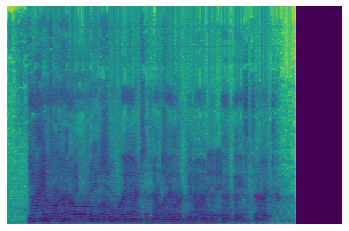

In [ ]:
#export
state = torch.load('../models/unet_5')
model.load_state_dict(state)
model.cpu()
model.eval()
for i, (xb, yb) in tqdm(enumerate(valid_dl)):
    xb,yb = xb.detach().cpu(), [yb[i].detach().cpu() for i in range(2)]
    #out = model(xb)
    #mask1 = MaskcIRM(out[:,:2,:,:])
    #mask2 = MaskcIRM(out[:,2:,:,:])
    
    #sep = mask1*xb, mask2*xb
    #sep = [sep[i].detach().cpu().squeeze() for i in range(len(sep))]
    #sep = [real2complex(sep[i]) for i in range(len(sep))]
    #spec1, spec2 = SpecImage(sep[0], 22050), SpecImage(sep[1], 22050)
    
    spec_mixed = xb.detach().cpu().squeeze()
    spec_mixed = real2complex(spec_mixed)
    spec_mixed = SpecImage(spec_mixed, 22050)
    
    spec_mixed.show()
    
    #audio1 = Spectify().decode(spec1)
    #audio2 = Spectify().decode(spec2)
    audio_mixed = Spectify().decode(spec_mixed)
    
    #audio1.listen()
    #audio2.listen()
    audio_mixed.listen()
    break


In [ ]:
print(type(yb))

<class 'list'>
